In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd

import nibabel as nib
import matplotlib.pylab as plt
import os

In [3]:
training_data = pd.read_csv(r'C:\Users\marth\Documents\RSNAchallenge\train.csv', encoding='latin1')
pos_data = pd.read_csv(r'C:\Users\marth\Documents\RSNAchallenge\train_localizers.csv', encoding='latin1')

In [4]:
training_data.head()

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,58,Male,CTA,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,71,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,48,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The .nii files are stored in memory as numpy's: <class 'numpy.memmap'>.


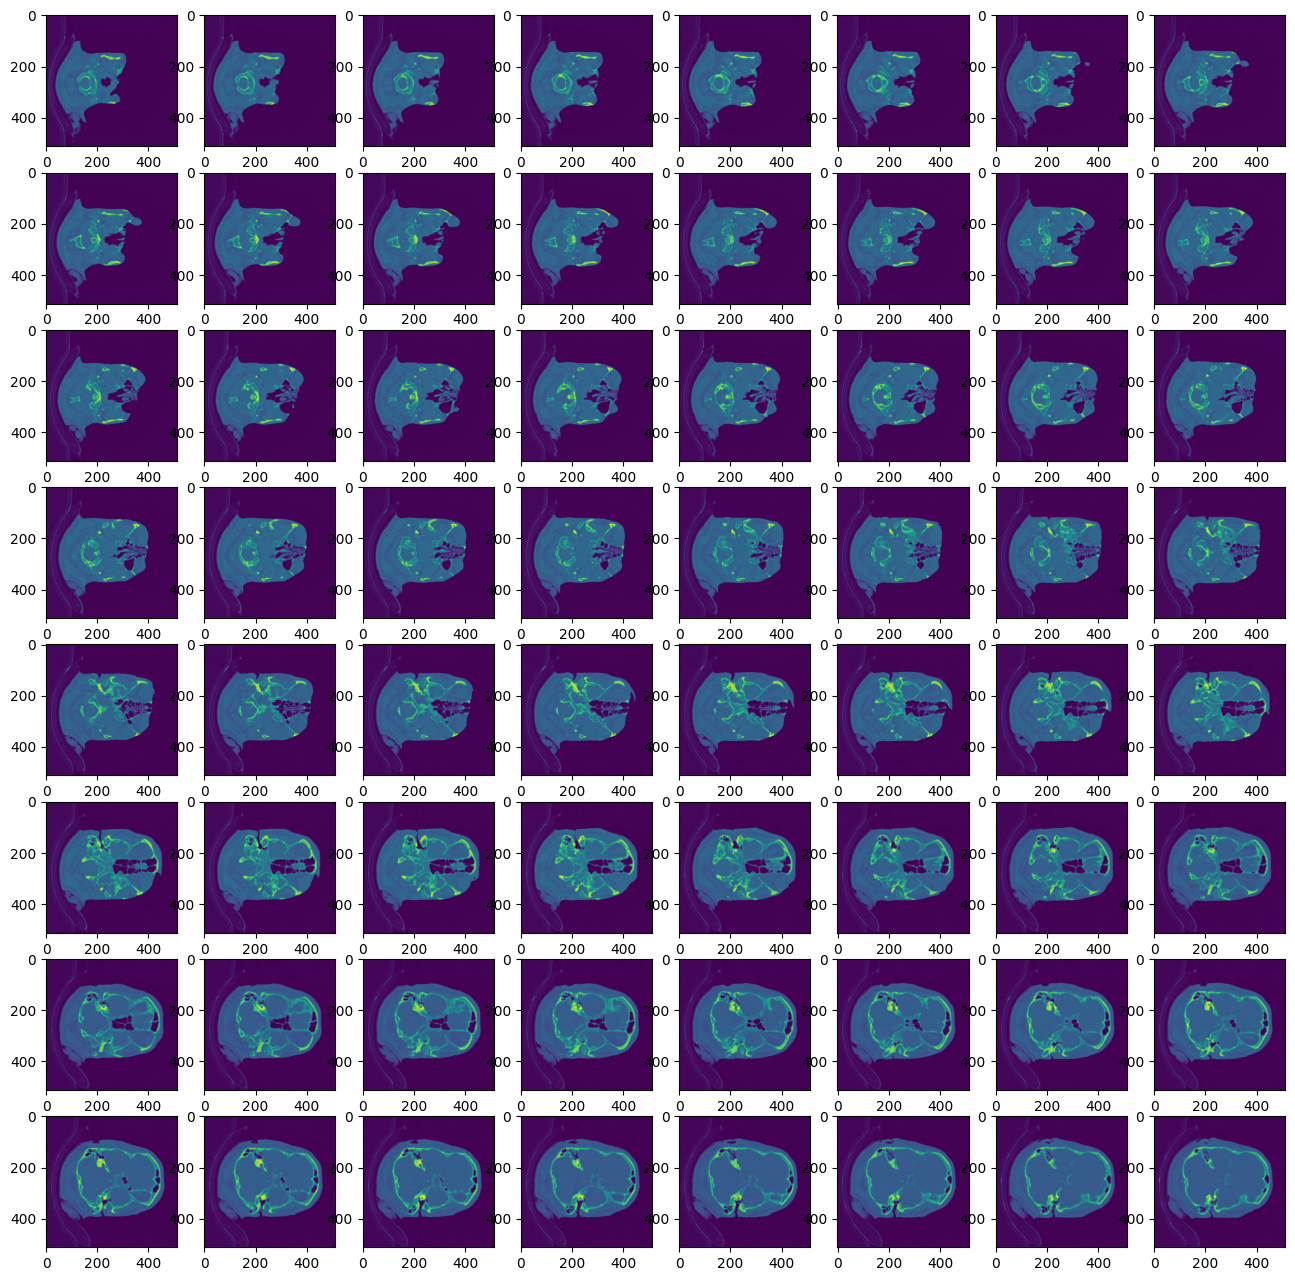

In [6]:




img_dir =  r'C:\Users\marth\Documents\RSNAchallenge\segmentations'
path = r'C:\Users\marth\Documents\RSNAchallenge\segmentations\1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381.nii'
img = nib.load(path).get_fdata()

print(f"The .nii files are stored in memory as numpy's: {type(img)}.")

plt.style.use('default')
fig, axes = plt.subplots(8, 8, figsize=(16,16))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[:,:,1 + i])
plt.show()



In [42]:
a = [1,2,3,4,5]
for x, y in enumerate(a):
    a[x] = 0

print(a)

[0, 0, 0, 0, 0]


In [68]:
def fix3d(path, target_depth=32):
        filepath = os.path.join(img_dir, path)
        scan = nib.load(filepath).get_fdata()
        d = scan.shape[2]
        if d < target_depth:
            pad_before = (target_depth - d) // 2
            pad_after = target_depth - d - pad_before
            scan = np.pad(scan, ((0,0), (0,0), (pad_before, pad_after)), mode='constant')
        elif d > target_depth:
            start = (d - target_depth) // 2
            scan = scan[:, :, start:start+target_depth]
        return scan



In [ ]:
class brainScans(Dataset):

    def __init__(self, data, img_dir, transform =None):

        self.img_dir = img_dir
        self.images = [ f for f in os.listdir(img_dir) if not f.endswith('_cowseg.nii') ] #don't put the mask in the training set
        print(img_dir)
        print(self.images[0])
        
        self.data = data
        self.transform = transform
    
    def __getitem__(self, idx):

        nii_path = os.path.join(self.img_dir, self.images[idx])

        scan =  nib.load(nii_path).get_fdata()

        scan = fix3d(nii_path)

        scan = torch.tensor(scan, dtype=torch.float32)  # <-- add dtype


        self.filename = self.images[idx].rstrip("_cowseg.nii")
        
        label = self.data.loc[self.data['SeriesInstanceUID'] == self.filename, 'Aneurysm Present'].values[0].astype(float) 
        
        return scan, label
        
    def __len__(self):
        return len(self.images)

    

### Note: After fixing the dataset run dataloader again!!!

In [69]:

dataset = brainScans(
    data = training_data,
    img_dir=img_dir,
    transform=None
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size


train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)



C:\Users\marth\Documents\RSNAchallenge\segmentations
1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381.nii


In [77]:

class cnn3D(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, 3, 2)
        self.conv2 = nn.Conv3d(16, 32, 3, 2)

        self.adaptive_pool = nn.AdaptiveAvgPool3d((3, 3, 3))

        self.fc1 = nn.Linear(864, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 2)
        

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)           
        x = F.relu(self.fc1(x))           
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))       
        x = self.fc4(x)                  
        return x


        ###x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 32*3*3*3)   



Ok so now that the dataset works I've run into another problem. These .nii files have different values for their third dimension ;( 

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

model = cnn3D().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

print("Training started:")

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        print("ran")
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')


Training started:
ran


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x27 and 864x120)